In [1]:
import pathlib
from fytok.Tokamak import Tokamak
from fytok.modules.Equilibrium import Equilibrium
from fytok.utils.logger import logger
from spdm.view.View import display
from spdm.data.File import File
from spdm.data.Path import Path
from spdm.data.Entry import Entry
from spdm.view import View as sp_view

WORKSPACE = "/home/salmon/workspace"  # "/ssd01/salmon_work/workspace/"
output_path = pathlib.Path(f"{WORKSPACE}/output/")

2023-12-10 08:26:01,236 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-10T08:26:00.957183.
 Job ID: fytok_salmon_surface_6335

###################################################################################################



In [2]:
equilibrium = Equilibrium(f"file+GEQdsk://{WORKSPACE}/gacode/neo/tools/input/profile_data/g141459.03890#equilibrium")
# tok = Tokamak(
#     "file+geqdsk:///home/salmon/workspace/fytok_tutorial/tutorial/data/g900003.00230_ITER_15MA_eqdsk16HR.txt",
#     device="east",
#     equilibrium={"code": {"name": "freegs"}},
# )

2023-12-10 08:26:03,182 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-10 08:26:03,185 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2023-12-10 08:26:03,197 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


In [3]:
with File("test.geqdsk", mode="w", format="GEQDSK") as fid:
    fid.write({"equilibrium": {"time_slice": [equilibrium.time_slice[0]]}})

2023-12-07 10:35:56,771 [    spdm]     INFO: Load module fytok.plugins.equilibrium.freegs
2023-12-07 10:35:56,775 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-07 10:35:56,778 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-07 10:35:56,784 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-07 10:35:56,790 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-07 10:35:56,794 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.freegs 
2023-12-07 10:35:56,807 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular


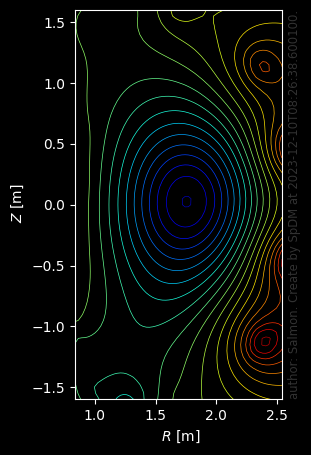

In [4]:
fig=sp_view.display(equilibrium.time_slice.current.profiles_2d.psi)